In [16]:
import numpy as np

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')

In [17]:
import pandas as pd

housing = pd.read_csv("datasets/housing/housing.csv")
housing.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY


# 테스트 세트 만들기
    - 과대적합을 방지하기 위해 테스트 세트 만들기
    - 그러나 분석을 통해 테스트 세트를 확인하면 안됨
    - 그 이유는 테스트 세트에서 드러난 패턴에 속아 특정 머신러닝을 선택하게 될 수 있기 떄문.
    - 이 모델로 일반화 오차를 추정하면 매우 낙관적인 추정이 되며 이를 '데이터 스누핑'편향이라고 한다.

## 무작위 샘플링 방식

In [18]:
# 데이터 셋이 크다면 일반적으로 좋음
# 하지만, 샘플링 편향이 생길 가능성이 큰 방법
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [19]:
train_set.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN


## 계층적 샘플링

<AxesSubplot:>

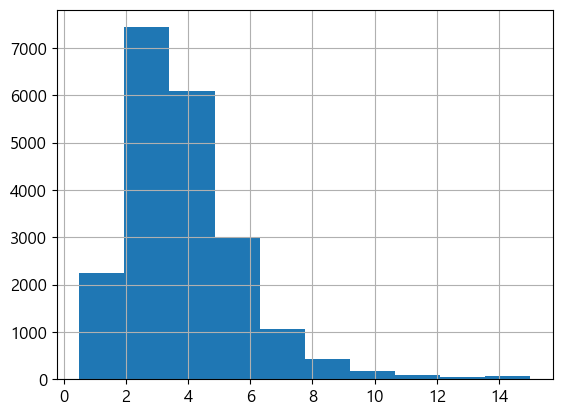

In [20]:
housing["median_income"].hist()

In [21]:
# 소득 카테고리 개수를 제한하기 위해 1.5로 나눕니다.
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# 5 이상은 5로 레이블합니다.
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

<AxesSubplot:>

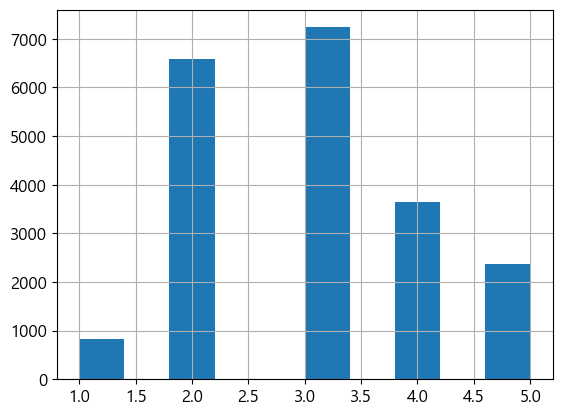

In [22]:
housing["income_cat"].hist()

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [24]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039971
Name: income_cat, dtype: float64

In [25]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [26]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [27]:
# Overall : 전체
# Stratified : 계층적 샘플링
# Random : 무작위 샘플링
# Rand. %error : 무작위 샘플링 오류율
# Strat. %error : 계층적 샘플링 오류율
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039971,0.040213,0.973236,0.364964
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 데이터 저장

In [29]:
strat_train_set.to_csv("datasets/housing/strat_train_set.csv", index = False)
strat_test_set.to_csv("datasets/housing/strat_test_set.csv", index = False)